In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [4]:
data_df = pd.read_json('json_data/All_Beauty.json', lines=True)

In [5]:
data_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [6]:
data_df.shape

(5269, 12)

In [7]:
data_df.dtypes

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
image             object
dtype: object

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         5269 non-null   int64 
 1   verified        5269 non-null   bool  
 2   reviewTime      5269 non-null   object
 3   reviewerID      5269 non-null   object
 4   asin            5269 non-null   object
 5   style           4624 non-null   object
 6   reviewerName    5269 non-null   object
 7   reviewText      5264 non-null   object
 8   summary         5264 non-null   object
 9   unixReviewTime  5269 non-null   int64 
 10  vote            552 non-null    object
 11  image           98 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 458.1+ KB


In [9]:
print('Number of missing values across columns: \n',data_df.isnull().sum())

Number of missing values across columns: 
 overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style              645
reviewerName         0
reviewText           5
summary              5
unixReviewTime       0
vote              4717
image             5171
dtype: int64


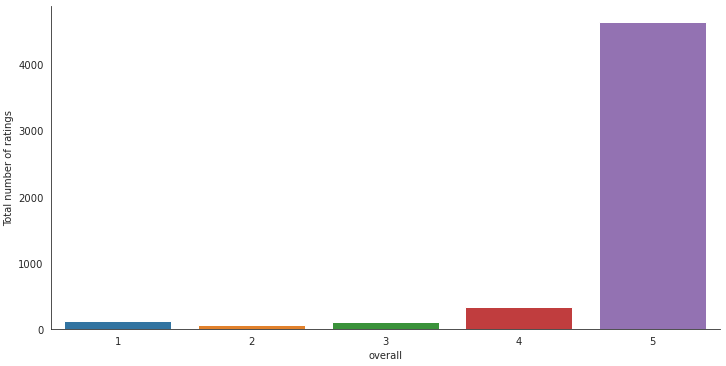

In [11]:
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=data_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [19]:
no_of_rated_products_per_user = data_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

asin
B0012Y0ZG2    1794
B000URXP6E     858
B001OHV1H4     489
B00006L9LC     489
B0009RF9DW     392
Name: overall, dtype: int64

In [14]:
no_of_rated_products_per_user.describe()

count    991.000000
mean       5.316852
std        0.791692
min        4.000000
25%        5.000000
50%        5.000000
75%        5.000000
max       12.000000
Name: overall, dtype: float64

In [17]:
##Collaborative Filtering
!pip install scikit-surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

     |████████████████████████████████| 11.8 MB 832 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=766591 sha256=f4e180020359d11f9e4265fbe88afb1a3d665e3027690b8314d5f6facfb87d84
  Stored in directory: /Users/yashchhabria/Library/Caches/pip/wheels/20/91/57/2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise
You should consider upgrading via the '/Users/yashchhabria/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [23]:
reader = Reader(rating_scale=(1, 5))
new_df = data_df[['reviewerID','asin','overall']]
data = Dataset.load_from_df(new_df,reader)

In [24]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [25]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [26]:
test_pred = algo.test(testset)

In [27]:
test_pred

[Prediction(uid='A24OO89UB5PY7J', iid='B000FI4S1E', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A3DA9MP7OGLPC0', iid='B0012Y0ZG2', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1THB1R8LWTMPV', iid='B0012Y0ZG2', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1JR5CZCFXPQMC', iid='B0012Y0ZG2', r_ui=5.0, est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A1JL5CJJDECOH4', iid='B0012Y0ZG2', r_ui=5.0, est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='AQG3FO72CYLU3', iid='B000URXP6E', r_ui=5.0, est=5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A3JDSBP01M7R2R', iid='B0009RF9DW', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A3AF038W92E3I', iid='B0012Y0ZG2', r_ui=5.0, est=5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A89GFB5RTGC8Z', iid='B001

In [28]:
accuracy.rmse(test_pred, verbose=True)


RMSE: 0.2803


0.28026542462653153

In [ ]:
accuracy.mae()